This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [1]:
from __future__ import division
import numpy as np
import os
import pylab
import seaborn
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Step 1 load data
nb_runs = 1
model_filenames = ['RMB','random']
models_data = {m:[] for m in model_filenames} 
models_bk = {m:[] for m in model_filenames} 

for filename in model_filenames:
    for j in range(nb_runs):
        full_filename = "../logs/"+filename+"_"+str(j)+".pickle"
        if os.path.isfile(full_filename):
            data = pickle.load(open(full_filename,"rb"))
            bk = pickle.load(open("../logs/"+filename+"_"+str(j)+"_book_keeping.pickle","rb"))
            bk['nb_iter'] = len(data['observations'])
            models_data[filename].append(data)
            models_bk[filename].append(bk)
            
nb_iter = bk['nb_iter'] #assumes every model and run has same number of iter 

In [3]:
for m in model_filenames:
    for i in range(nb_runs):
        print m+" run "+str(i)
        print "{} iterations loaded: {} arm, {} sound".format(models_bk[m][i]['nb_iter'],
                                                      models_bk[m][i]['nb_motor_it'],
                                                      models_bk[m][i]['nb_sound_it'])

RMB run 0
16500 iterations loaded: 1578 arm, 14922 sound
random run 0
16500 iterations loaded: 1634 arm, 14866 sound


In [4]:
def process_data(sub_outcomes, data, bk):
    cpt = 0
    zero_like = [-0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487 ,-1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
     -0.87179487, -1.     ,     0.73195876, -0.87179487,-1.     ,     0.73195876]
    culb_replaced = []
    zero_like_sum = -11.398361089082734
    for n,d in sub_outcomes.items():
        sub_outcomes[n]['traj'] = []
        sub_outcomes[n]['raw'] = []
        if n == 'culbuto':
            sub_outcomes[n]['arm_it_only'] = []
        for i in range(bk['nb_iter']):
            if n == 'culbuto':
                if data['chosen_modules'][i] in diva_modules: # we do not care about objects when vocalizing
                    #print 'hhh'
                    if not sum(data['observations'][i][d['range']]) == zero_like_sum:
                        culb_replaced.append(i)
                        data['observations'][i][d['range']] = zero_like
                
                if not sum(data['observations'][i][d['range']]) == zero_like_sum:
                    sub_outcomes[n]['arm_it_only'] += np.split(data['observations'][i][d['range']],
                                                                   d['nb_traj_steps']) 
            #print 'stop'
            sub_outcomes[n]['traj'].append(data['observations'][i][d['range']])
            sub_outcomes[n]['raw'] += np.split(data['observations'][i][d['range']], d['nb_traj_steps'])
        sub_outcomes[n]['raw'] = np.array(sub_outcomes[n]['raw'])
        if n == 'culbuto':
            sub_outcomes[n]['arm_it_only'] = np.array(sub_outcomes[n]['arm_it_only'])
    print len(sub_outcomes['hand']['traj'])
    return culb_replaced
    

# Define motor and sensory spaces:
s_hand = range(3, 33)
s_culbuto_1 = range(33, 63)
s_self_sound = range(63, 73)
s_caregiver_sound = range(73, 83)

arm_modules = [1,3,6]
diva_modules = [12,14]

# Extract relevant observation sub parts
models_sub_outcomes = {}
for m in model_filenames:
    models_sub_outcomes[m] = []
    sub_outcomes = {'hand':{'range': s_hand, 'nb_traj_steps': 10},
                'culbuto':{'range': s_culbuto_1, 'nb_traj_steps': 10},
                'agent_sound':{'range': s_self_sound, 'nb_traj_steps': 5},
                'caregiver_sound':{'range': s_caregiver_sound, 'nb_traj_steps': 5}}
    for i in range(nb_runs):
        culbuto_replaced = process_data(sub_outcomes, models_data[m][i], models_bk[m][i])
        models_sub_outcomes[m].append(sub_outcomes)
        models_data[m][i]['culbuto_replaced'] = culbuto_replaced
    

16500
16500


In [5]:
print models_sub_outcomes['RMB'][0]['culbuto']['arm_it_only'].shape

(16040, 3)


In [22]:
# Grid cell exploration curves
metric = ['hand','culbuto','agent_sound']
bins = [10,100,50]

nb_metrics = len(metric)
plot_every = 100
plot_steps = np.arange(plot_every,((nb_iter // plot_every)+1)*plot_every,plot_every)

models_mean_explo = []
models_std_explo = []
for model in model_filenames:
    print model
    explo = np.zeros((nb_metrics,nb_runs,len(plot_steps)))
    for r in range(nb_runs):
        print r
        for i, plot_idx in enumerate(plot_steps):
            for m_idx, m in enumerate(metric):
                    nb_dims = models_sub_outcomes[model][r][m]['raw'].shape[1]
                    samples = models_sub_outcomes[model][r][m]['raw'][:plot_idx,:]
                    nb_explored_cells = len(np.unique(stats.binned_statistic_dd(samples,
                                                                                np.arange(len(samples)),
                                                                                bins = bins[m_idx],
                                                                                range=[[-1,1]]*nb_dims).binnumber))
                    nb_cells = bins[m_idx]**nb_dims
                    explo[m_idx,0,i] = (nb_explored_cells / nb_cells)*100
    

    mean_explo = np.mean(explo,axis=1)
    std_explo = np.std(explo,axis=1)
    
    models_mean_explo.append(mean_explo)
    models_std_explo.append(std_explo)

RMB
0
random
0


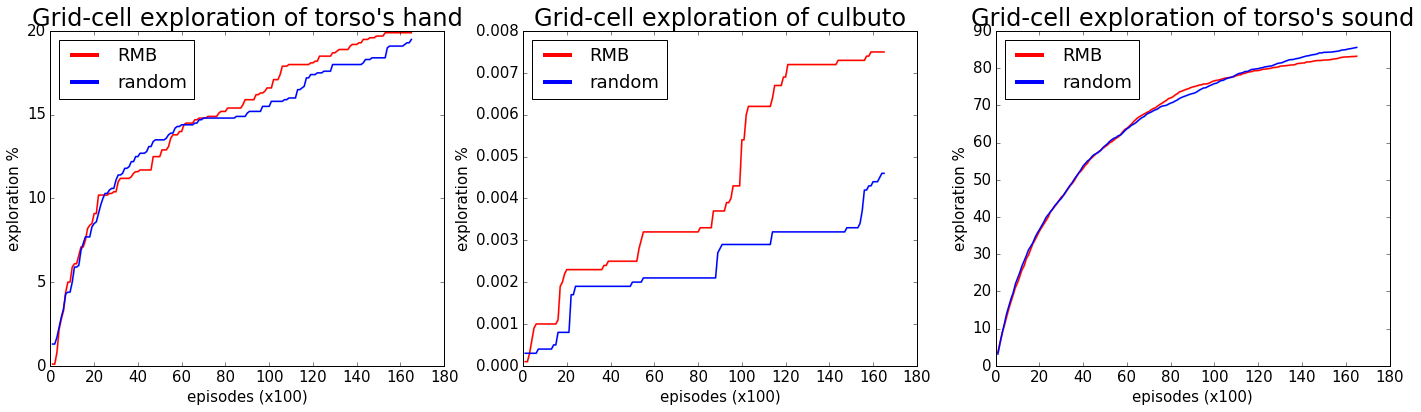

In [23]:
def plot_with_std(ax,x,y,err,color,shade_color,label,y_min=None,y_max=None, legend=False, title=None):
    plt.rcParams.update({'font.size': 15})
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = ax.legend(loc='upper left')
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('episodes (x100)')
    ax.set_ylabel('exploration %')
    if y_min is not None:
        ax.ylim(ymin=y_min,ymax=y_max)
    if title:
        ax.set_title(title, fontsize=24)

colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
title_info = ["torso's hand", "culbuto", "torso's sound"]
plotpos=[131,132,133]

f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(24,6))
ax = [ax0, ax1, ax2]
for j, (mean_explo, std_explo) in enumerate(zip(models_mean_explo, models_std_explo)):
    for i,m in enumerate(metric):
        y = mean_explo[i,:]
        err = std_explo[i,:]
        title = 'Grid-cell exploration of '
        plot_with_std(ax[i], plot_steps//100,y,err,colors[j],shades_colors[j],model_filenames[j],
                      title=title+title_info[i], legend=True)
    #plt.savefig("grid_cell_exploration.pdf", bbox_inches='tight')
plt.show()


RMB
(16040, 3)


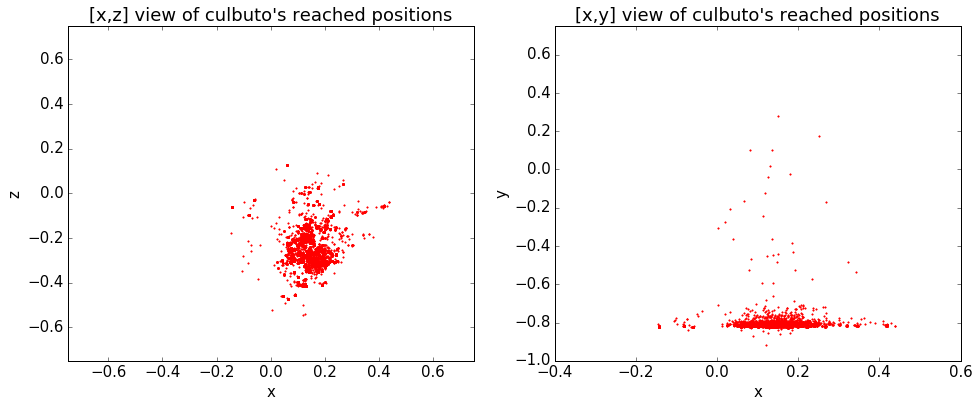

random
(16340, 3)


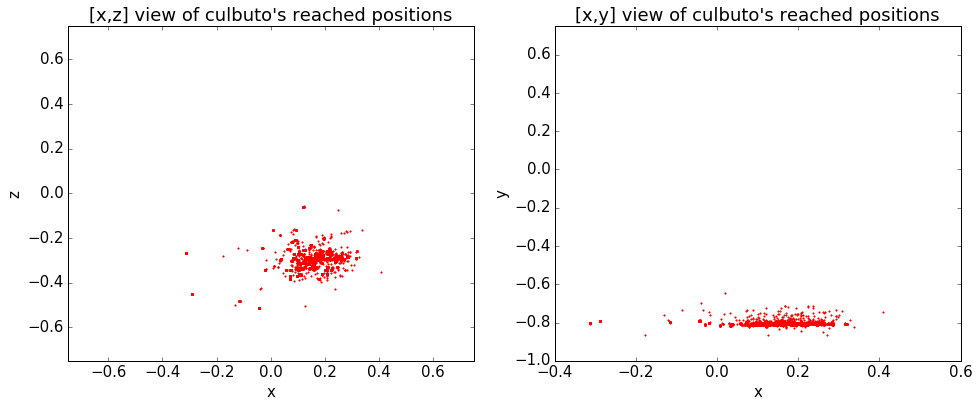

In [8]:
#Quantitative view of culbuto's reached positions
for i,m_name in enumerate(model_filenames):
    print m_name
    sub_outcomes = models_sub_outcomes[m_name][0]
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    a = np.array(sub_outcomes['culbuto']['arm_it_only'])
    print a.shape
    ax1.plot(a[:,0],a[:,2],'r.',markersize=3)
    ax1.set_xlim(-0.75,0.75)
    ax1.set_ylim(-0.75,0.75)
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.set_title("[x,z] view of culbuto's reached positions")

    ax2.plot(a[:,0],a[:,1],'r.',markersize=3)
    ax2.set_xlim(-0.4,0.6)
    ax2.set_ylim(-1,0.75)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title("[x,y] view of culbuto's reached positions")

    #plt.savefig("culbuto_exploration.pdf", bbox_inches='tight')
    #plt.savefig("culbuto_exploration.png", bbox_inches='tight')
    plt.show()


In [9]:
zero = [-0.87179487, -1.     ,     0.73195876]
for p in a:
    if p[0] == -0.87179487:
        print 'sho'
    if (p == zero).all():
        print damn

In [10]:
import pickle
from rospkg.rospack import RosPack
import rospy
from os.path import join

# Sound config
def compress_sound_traj(sound):
    assert(len(sound) == 100)
    f1s = sound[:50]
    f3s = sound[50:]
    return np.append(f1s[np.array([0, 12, 24, 37, 49])],f3s[np.array([0, 12, 24, 37, 49])])

v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))

# Retrieve caregiver sounds and trajectories from json
rospack = RosPack()
with open(join(rospack.get_path('pobax_playground'), 'config', 'human_sounds.pickle')) as f:
    full_human_motor_traj, full_human_sounds_traj  = pickle.load(f)
human_sounds = full_human_sounds_traj.keys()
rospy.loginfo('Voice node using the word %s for culbuto name' % human_sounds[0])

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)

human_sounds = ['eyu', 'oey', 'eou', 'oyi']
print "human sounds", human_sounds

human_sounds_traj = dict()
human_sounds_traj_std = dict()
best_vocal_errors = {}
best_vocal_errors_evolution = []
for hs in human_sounds:
    best_vocal_errors[hs] = 10.
    human_sounds_traj[hs] = compress_sound_traj(full_human_sounds_traj[hs])
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    
        
sound_tol = 0.4

human sounds ['eyu', 'oey', 'eou', 'oyi']


['0-10', '20-30', '40-50', '60-70', '80-90', '100-110', '120-130', '140-150']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


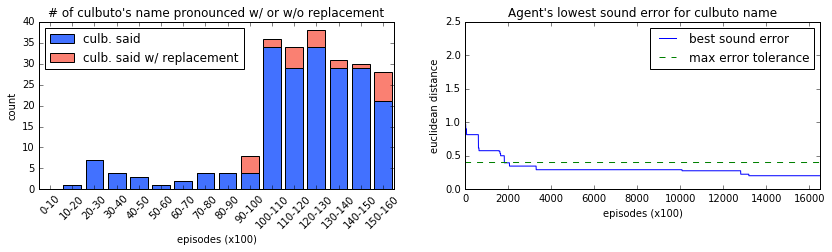

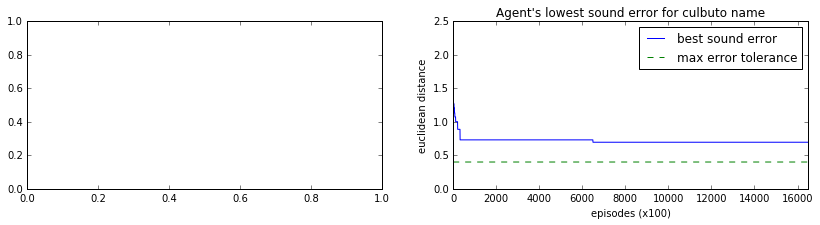

In [25]:
# Plot culbuto name frequency
def analysis_sound(sound, best_vocal_error):
        #return human_sounds[2]
        #print human_sounds_traj
        for hs in human_sounds:
            #sound = np.array([f[0] for f in diva_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in diva_traj[[0, 12, 24, 37, 49]]])
            error = np.linalg.norm(np.array(human_sounds_traj[hs]) - sound)
            if error < best_vocal_error:
                best_vocal_error = error
            if error < sound_tol:
                #print "***********Agent says", hs
                return hs, best_vocal_error
        return None, best_vocal_error

plt.rcParams.update({'font.size': 10})
for m in model_filenames:
    for r in range(nb_runs):
        sub_outcomes = models_sub_outcomes[m][r]
        vocal_errors = []
        culb_name_said = []
        best_vocal_error = 10.
        for i,s in enumerate(sub_outcomes['agent_sound']['traj']):
            #denormalize s
            original_s = [d + 8.5 for d in s[:5]] + [d + 10.25 for d in s[5:]]    
            res, best_vocal_error = analysis_sound(original_s, best_vocal_error)
            vocal_errors.append(best_vocal_error)
            if res == 'eyu':
                culb_name_said.append(i)

        # Plot sound error evolution
        f, (ax2, ax1) = plt.subplots(1,2,figsize=(14,3))
        ax1.plot(vocal_errors,color='blue',label='best sound error')
        ax1.plot([sound_tol]*len(vocal_errors),ls='--',
                 color='green', 
                 label='max error tolerance')
        ax1.set_title("Agent's lowest sound error for culbuto name")
        ax1.set_ylabel('euclidean distance')
        ax1.set_xlabel('episodes (x100)')
        ax1.set_xlim(0,len(vocal_errors))
        ax1.legend()

        # Barplot plot
        if len(culb_name_said) > 0:
            culb_said_not_replaced = []
            culb_said_replaced = []
            for episode in culb_name_said:
                if episode in models_data[m][r]['culbuto_replaced']:
                    culb_said_replaced.append(episode)
                else:
                    culb_said_not_replaced.append(episode)
            barplot_step = 1000
            barplot_steps = np.arange(0,((nb_iter // barplot_step)+1)*barplot_step,barplot_step)
            count_culb_not_replaced = stats.binned_statistic(culb_said_not_replaced,
                                         np.arange(len(culb_said_not_replaced)),
                                         statistic='count',
                                         bins=barplot_steps).statistic

            count_culb_replaced = stats.binned_statistic(culb_said_replaced,
                                         np.arange(len(culb_said_replaced)),
                                         statistic='count',
                                         bins=barplot_steps).statistic

            width = 0.8      # the width of the bars: can also be len(x) sequence
            ind = np.arange(len(count_culb_replaced))    # the x locations for the groups
            p1 = ax2.bar(ind, count_culb_not_replaced, color=(0.2588,0.4433,1.0),align='center', width=width)
            p2 = ax2.bar(ind, count_culb_replaced, color='salmon', bottom=count_culb_not_replaced,align='center', width=width)

            
            x_labels= []
            for i,val in enumerate(barplot_steps):
                if i < len(barplot_steps)-1:
                    x_labels.append(str(val//100)+'-'+str(barplot_steps[i+1]//100))

            print x_labels[0::2]
            ax2.set_xticks(ind)
            ax2.set_xticklabels(x_labels,rotation = 45)
            print ind
            ax2.set_xlim(min(ind)-0.5,max(ind)+0.5)
            
            ax2.set_ylabel('count')
            ax2.set_xlabel('episodes (x100)')
            ax2.set_title("# of culbuto's name pronounced w/ or w/o replacement")
            ax2.legend((p1[0],p2[0]),('culb. said','culb. said w/ replacement'), loc=2)

            plt.savefig(m+"culbuto_name_pronounced.pdf", bbox_inches='tight')
            plt.show()
        

[ 1510  1520  1530 ... 16480 16490 16500]


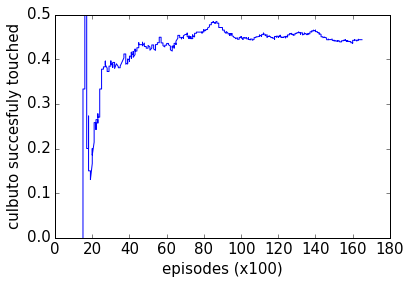

16500
16500


In [24]:
def is_culbuto_touched(culb_traj):
        thr = 9e-06 #variance threshold
        xs = culb_traj[0::3]
        ys = culb_traj[1::3]
        zs = culb_traj[2::3]
        if (np.var(xs) > thr) or (np.var(ys) > thr) or (np.var(zs) > thr):
            return True
        else:
            return False

plot_every = 10
plot_steps = np.arange(plot_every,((nb_iter // plot_every)+1)*plot_every,plot_every)
# Evolution of succesfull culbuto touching
m = 'RMB'
print plot_steps[150:]
for r in range(nb_runs):
    trying_to_move_culb = []
    moved_culb_while_trying = []
    culb_trajs = models_sub_outcomes[m][r]['culbuto']['traj']
    chosen_modules = models_data[m][r]['chosen_modules']

    # extract data
    for i in range(nb_iter):
        if chosen_modules[i] == 3: #trying to move culbuto
            trying_to_move_culb.append(1)
            if is_culbuto_touched(culb_trajs[i]):
                moved_culb_while_trying.append(1)
            else:
                moved_culb_while_trying.append(-1)
        else:
            trying_to_move_culb.append(0)
            moved_culb_while_trying.append(0)
    culbuto_accuracies = []

    # compute plot values
    for i in plot_steps:
        if trying_to_move_culb[:i].count(1) != 0:
            culb_accuracy = moved_culb_while_trying[:i].count(1) / trying_to_move_culb[:i].count(1)
            culbuto_accuracies.append(culb_accuracy)
        else:
            #print 'hehe'
            culbuto_accuracies.append(0)

    # actual plotting
    plt.figure()
    plt.plot(plot_steps[150:]//100,culbuto_accuracies[150:])
    plt.xlabel('episodes (x100)')
    plt.ylabel('culbuto succesfuly touched')
    
    plt.show()
        
            
            
            
    print len(trying_to_move_culb)
    print len(moved_culb_while_trying)


In [ ]:
a = [0,1,0,1,1,1]
b = [0,-1,0,1,1,1]
print a.count(1)
print b.count(1)
print  b.count(1) / a.count(1)


In [ ]:
plot_steps//100

In [ ]:
for m in model_filenames:
    print models_bk[m][0]['nb_culbuto_touched']